<a href="https://colab.research.google.com/github/pandaharya/ujiantesis/blob/main/5kelas_klasifikasi_batikJawa_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from collections import Counter
import pandas as pd
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn
import numpy as np
import tqdm
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image

from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

In [3]:
from torch import Tensor, nn
from torch.nn.functional import interpolate

In [4]:
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model

#from keras.utils import multi_gpu_model

#if tf.__version__ == "2.4.0":
#    from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
#else:
#    from tensorflow.keras.utils import multi_gpu_model

#from tensorflow.keras.utils import multi_gpu_model

In [5]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
traindir = f"/content/drive/MyDrive/Datasetbatikpenelitianlain/Train"
validdir = f"/content/drive/MyDrive/Datasetbatikpenelitianlain/Val"
testdir = f"/content/drive/MyDrive/Datasetbatikpenelitianlain/Test"

In [8]:
#!pip install keras==2.9
#!pip install tensorflow 

#!pip install patchify    #To install and import other mentioned libraries  in code
#!pip install segmentation_models

In [9]:
#!pip install keras==2.2.4

In [10]:
"""Load Cuda """
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
""""""""""""""""""

''

In [11]:
#from tensorflow.python.keras.utils import multi_gpu_utils

save_file_name = f'resnet50-transfer.pt'
checkpoint_path = f'resnet50-transfer.pth'

# Change to fit hardware
batch_size = 16

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu_model = True
    else:
        multi_gpu_model = False
print(train_on_gpu)
print(multi_gpu_model)

Train on gpu: True
1 gpus detected.
True
False


In [12]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.5, 1.0)),
        #transforms.RandomRotation(degrees=45),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.CenterCrop(100),
        transforms.RandomGrayscale(),
        #transforms.RandomInvert(),
        #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
        # Test does not use augmentation
    'test':
    transforms.Compose([
        #transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

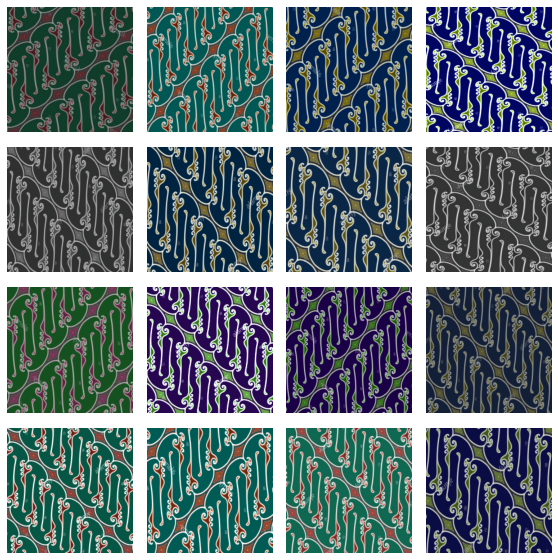

In [13]:
ex_img = Image.open('/content/drive/MyDrive/Datasetbatikpenelitianlain/Train/Parang/77.jpg')

t = image_transforms['train']
plt.figure(figsize=(8, 8))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [14]:
import glob

In [15]:
image_list = glob.glob('256_ObjectCategories/*/*.jpg')
print(len(image_list))

0


In [16]:
# Datasets from folders
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'valid':
    datasets.ImageFolder(root=validdir, transform=image_transforms['valid']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=0),
    'val': DataLoader(data['valid'], batch_size=batch_size, shuffle=True,num_workers=0),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True,num_workers=0)
}

In [17]:
# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [18]:
categories = []
for d in os.listdir(traindir):
    categories.append(d)
    
n_classes = len(categories)
print(f'There are {n_classes} different classes.')

There are 5 different classes.


In [19]:
class_to_idx = data['train'].class_to_idx
idx_to_class = {
    idx: class_
    for class_, idx in data['train'].class_to_idx.items()
}

In [20]:
train_cnts = Counter([idx_to_class[x] for x in data['train'].targets])
val_cnts = Counter([idx_to_class[x] for x in data['valid'].targets])
test_cnts = Counter([idx_to_class[x] for x in data['test'].targets])

In [21]:
train_cnts = pd.DataFrame({'batik_papua' :list(train_cnts.keys()), 'train_cnt': list(train_cnts.values())})
val_cnts = pd.DataFrame({'batik_papua' :list(val_cnts.keys()), 'val_cnt': list(val_cnts.values())})
test_cnts = pd.DataFrame({'batik_papua' :list(test_cnts.keys()), 'test_cnt': list(test_cnts.values())})

In [22]:
cnt_df = pd.merge(train_cnts,val_cnts,on='batik_papua',how='left').merge(test_cnts,on='batik_papua',how='left')

In [23]:
cnt_df.head()

,batik_papua,train_cnt,val_cnt,test_cnt
0,Ceplok,80,10,10
1,Kawung,80,10,10
2,MegaMendung,80,10,10
3,Nitik,80,10,10
4,Parang,80,10,10


#Create Models

In [24]:
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [25]:
for param in model.parameters():
    param.requires_grad = False

In [26]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
n_inputs = model.fc.in_features

In [28]:
model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(inplace=True),
                      #nn.ReLU(), 
                      #nn.Dropout(0.4),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      #nn.Dropout(0.4),
                      #nn.Linear(128, 32),
                      #nn.ReLU(), 
                      #nn.Dropout(0.4),
                      nn.Linear(128, n_classes),                   
                      nn.LogSoftmax(dim=1)
                      )

In [29]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=5, bias=True)
  (5): LogSoftmax(dim=1)
)

In [30]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,066,117 total parameters.
558,085 training parameters.


In [31]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu_model:
    model = nn.DataParallel(model)

In [32]:
if multi_gpu_model:
    print(model.module.fc)
else:
    print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=5, bias=True)
  (5): LogSoftmax(dim=1)
)


In [33]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Ceplok'), (1, 'Kawung'), (2, 'MegaMendung'), (3, 'Nitik'), (4, 'Parang')]

In [34]:
#criterion = nn.NLLLoss()
#optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=3e-3, momentum = 0.9, weight_decay=5e-4)

In [35]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([5, 128])
torch.Size([5])


In [36]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=5,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [37]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=150,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.5966 	Validation Loss: 1.5476
		Training Accuracy: 27.25%	 Validation Accuracy: 48.00%

Epoch: 1 	Training Loss: 1.5092 	Validation Loss: 1.4045
		Training Accuracy: 47.75%	 Validation Accuracy: 62.00%

Epoch: 2 	Training Loss: 1.3023 	Validation Loss: 1.1535
		Training Accuracy: 67.75%	 Validation Accuracy: 72.00%

Epoch: 3 	Training Loss: 1.0383 	Validation Loss: 0.8501
		Training Accuracy: 74.25%	 Validation Accuracy: 68.00%

Epoch: 4 	Training Loss: 0.7892 	Validation Loss: 0.7663
		Training Accuracy: 72.75%	 Validation Accuracy: 72.00%

Epoch: 5 	Training Loss: 0.6478 	Validation Loss: 0.5737
		Training Accuracy: 78.25%	 Validation Accuracy: 80.00%

Epoch: 6 	Training Loss: 0.6147 	Validation Loss: 0.5829
		Training Accuracy: 79.00%	 Validation Accuracy: 74.00%

Epoch: 7 	Training Loss: 0.6200 	Validation Loss: 0.4606
		Training Accuracy: 77.25%	 Validation Accuracy: 82.00%

Epoch: 8 	Training Loss: 0.5390 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

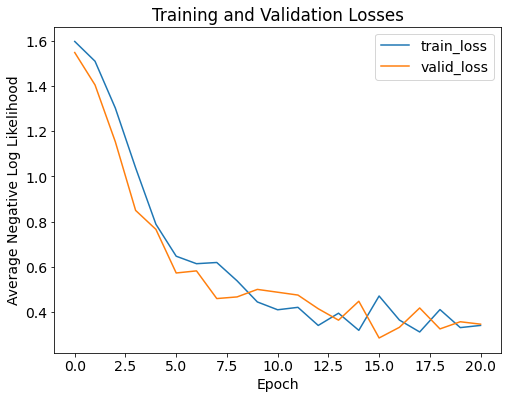

In [38]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

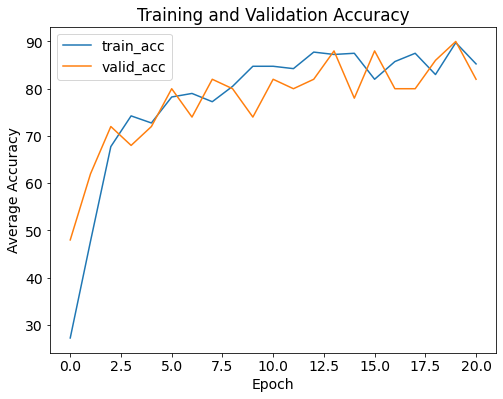

In [39]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

#Save Model

In [40]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu_model:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu_model:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

In [41]:
save_checkpoint(model, path=checkpoint_path)

#checkpoint

In [42]:
def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')

    # Move to gpu
    if multi_gpu_model:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [43]:
model, optimizer = load_checkpoint(path=checkpoint_path)

24,066,117 total parameters.
558,085 total gradient parameters.


#Inference

In [44]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [45]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns
        
    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

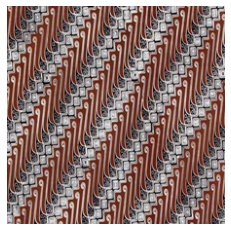

In [46]:
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(categories)
    root = testdir +"/"+ c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [47]:
img, top_p, top_classes, real_class = predict(random_test_image(), model,topk=2)

In [48]:
top_p, top_classes, real_class

(array([0.9787871 , 0.01377012], dtype=float32), ['Nitik', 'Ceplok'], 'Nitik')

#Display Preds

In [49]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

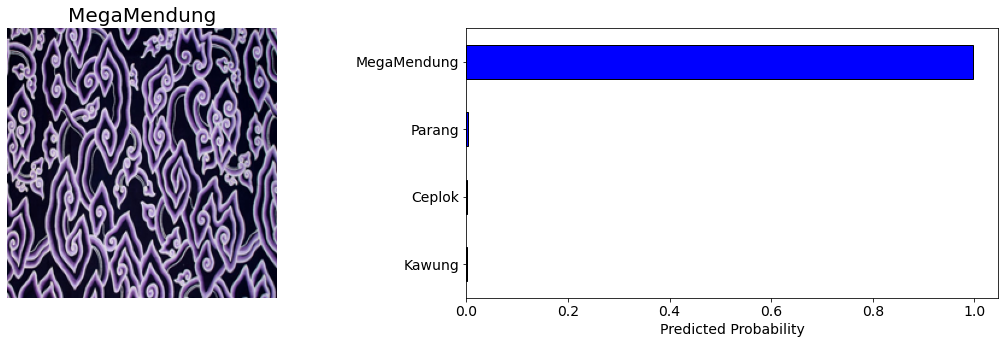

In [50]:
display_prediction(random_test_image(), model, topk=4)

In [51]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [52]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
  res = accuracy(model(features.to('cuda')), targets, topk=(1,1))
else:
  res = accuracy(model(features), targets, topk=(1,1))
print(res)

[75.0, 75.0]


#Function to Evaluate Model Over All Classes

In [53]:
def evaluate(model, test_loader, criterion, topk=(1, 3)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """
    confusion_matrix = torch.zeros(n_classes, n_classes)
    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            _, predscm = torch.max(out, 1)
            for t, p in zip(targets.view(-1), predscm.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
            
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'}),confusion_matrix

criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results,confusion_matrix = evaluate(model, dataloaders['test'], criterion)

In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(f'confusion_matrix.png')
    return plt

In [55]:
classnames = [model.idx_to_class[i] for i in range(0,n_classes)]

Confusion matrix, without normalization


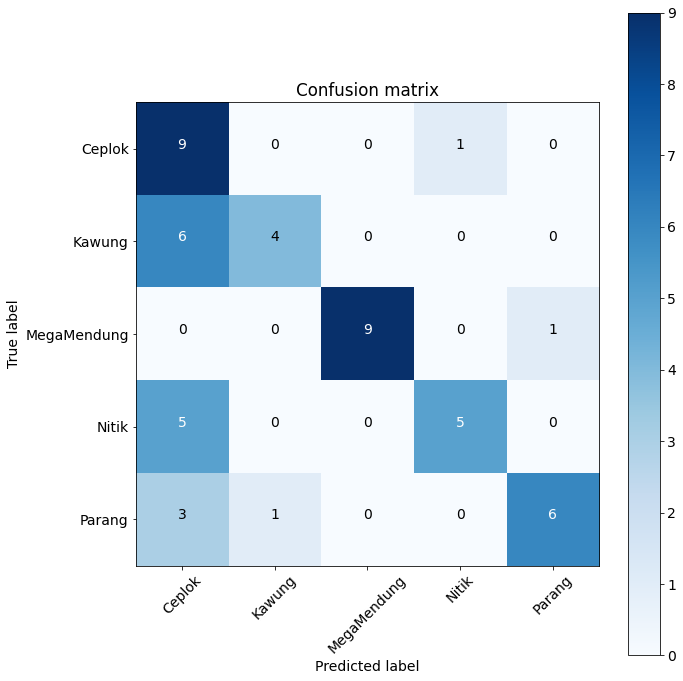

In [56]:
plt.figure(figsize=(10,10))
plt = plot_confusion_matrix(confusion_matrix, classnames)

In [57]:
def cm_as_dataframe(cm):
    cm = pd.DataFrame(cm)
    cm.columns = classnames
    cm.index = classnames
    cm = cm.reset_index()
    return cm

cm_as_dataframe(confusion_matrix.cpu().numpy()).to_csv(f'confmat.csv',index=None)

In [58]:
print(f"Overall Accuracy:{confusion_matrix.diag().sum()/confusion_matrix.sum()}")

#rint(f"Overall Accuracy:{confusion_matrix.diag().f()/confusion_matrix.sum()}")

Overall Accuracy:0.6600000262260437


In [59]:
results = results.merge(cnt_df,left_on='class',right_on='batik_papua')

In [60]:
results

,class,top1,top3,loss,batik_papua,train_cnt,val_cnt,test_cnt
0,Ceplok,90.0,100.0,0.484512,Ceplok,80,10,10
1,Kawung,40.0,90.0,1.209877,Kawung,80,10,10
2,MegaMendung,90.0,100.0,0.247200,MegaMendung,80,10,10
3,Nitik,50.0,100.0,1.239586,Nitik,80,10,10
4,Parang,60.0,90.0,1.637349,Parang,80,10,10


In [61]:
results.to_csv(f'test_accuracy.csv',index=None)

In [62]:
def display_category(model, category, n=4):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    #print(category_results.iloc[:, :10], '/n')

    images = np.random.choice(
        os.listdir(testdir + "/"+category + '/'), size=n, replace=False)

    for img in images:
        display_prediction(testdir +"/"+ category + '/' + img, model, 4)

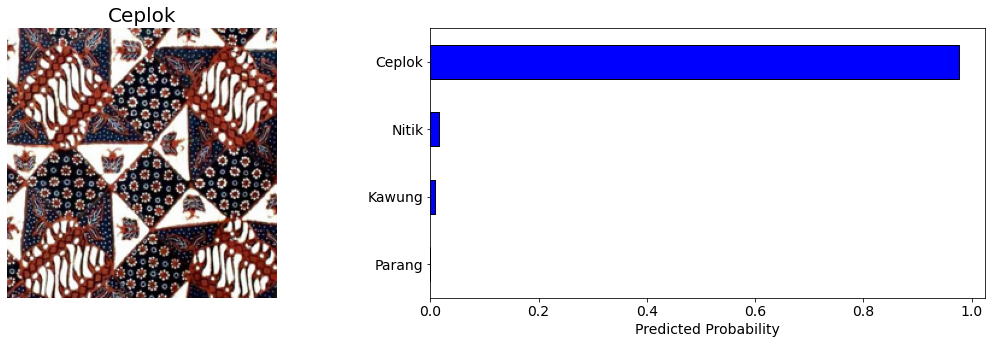

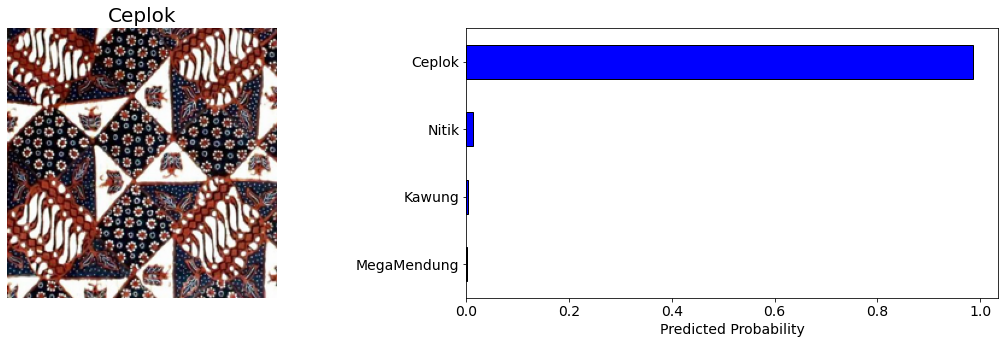

In [63]:
display_category(model, 'Ceplok', n=2)

#Test Time Augmentation

In [64]:
import tqdm as tqdm

In [65]:
# Image transformations
tta_random_image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ])

In [66]:
# Datasets from folders
ttadata = {
    'test':
    datasets.ImageFolder(root=testdir, transform=tta_random_image_transforms)
}


# Dataloader iterators
ttadataloader = {
    'test': DataLoader(ttadata['test'], batch_size=512, shuffle=False,num_workers=0)
}

In [67]:
def tta_preds_n_averaged(model, test_loader,n=5):
    """Returns the TTA preds from a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        
    Returns
    --------
        results (array): results for each category

    """
    # Hold results
    results = np.zeros((len(test_loader.dataset), n_classes))
    bs = test_loader.batch_size
    model.eval()
    with torch.no_grad():
        #aug loop:
        for _ in range(n):
            # Testing loop
            tmp_pred = np.zeros((len(test_loader.dataset), n_classes))
            for i,(data, targets) in enumerate(tqdm.tqdm(test_loader)):
                # Tensors to gpu
                if train_on_gpu:
                    data, targets = data.to('cuda'), targets.to('cuda')

                # Raw model output
                out = model(data)
                tmp_pred[i*bs:(i+1)*bs] = np.array(out.cpu())
            
            results+=tmp_pred
    return results/n

In [68]:
preds_tta = tta_preds_n_averaged(model, ttadataloader['test'])

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


In [69]:
preds_tta_index = np.argmax(preds_tta,axis=1)
print(f"TTA Accuracy: {sum(ttadata['test'].targets==preds_tta_index)/len(preds_tta_index)}")

TTA Accuracy: 0.74


In [70]:
preddf = pd.DataFrame({'ttapreds':preds_tta_index,'truelabel':ttadata['test'].targets})
preddf['tta_acc'] = preddf['ttapreds'] == preddf['truelabel']
preddf['class'] = preddf['truelabel'].apply(lambda x: idx_to_class[x])
category_tta= preddf.groupby(['class']).aggregate({'tta_acc':np.mean}).reset_index()

In [71]:
ttaresults = results.merge(category_tta,on='class',how='left')[['class','top1','tta_acc', 'train_cnt', 'val_cnt',
       'test_cnt']]

In [72]:
ttaresults.columns = ['class', 'normal_acc', 'tta_acc', 'train_cnt', 'val_cnt', 'test_cnt']

In [73]:
ttaresults['tta_acc']*=100

In [74]:
ttaresults

,class,normal_acc,tta_acc,train_cnt,val_cnt,test_cnt
0,Ceplok,90.0,90.0,80,10,10
1,Kawung,40.0,70.0,80,10,10
2,MegaMendung,90.0,80.0,80,10,10
3,Nitik,50.0,60.0,80,10,10
4,Parang,60.0,70.0,80,10,10
